# Transfer Learning for Multi-class Image Classification

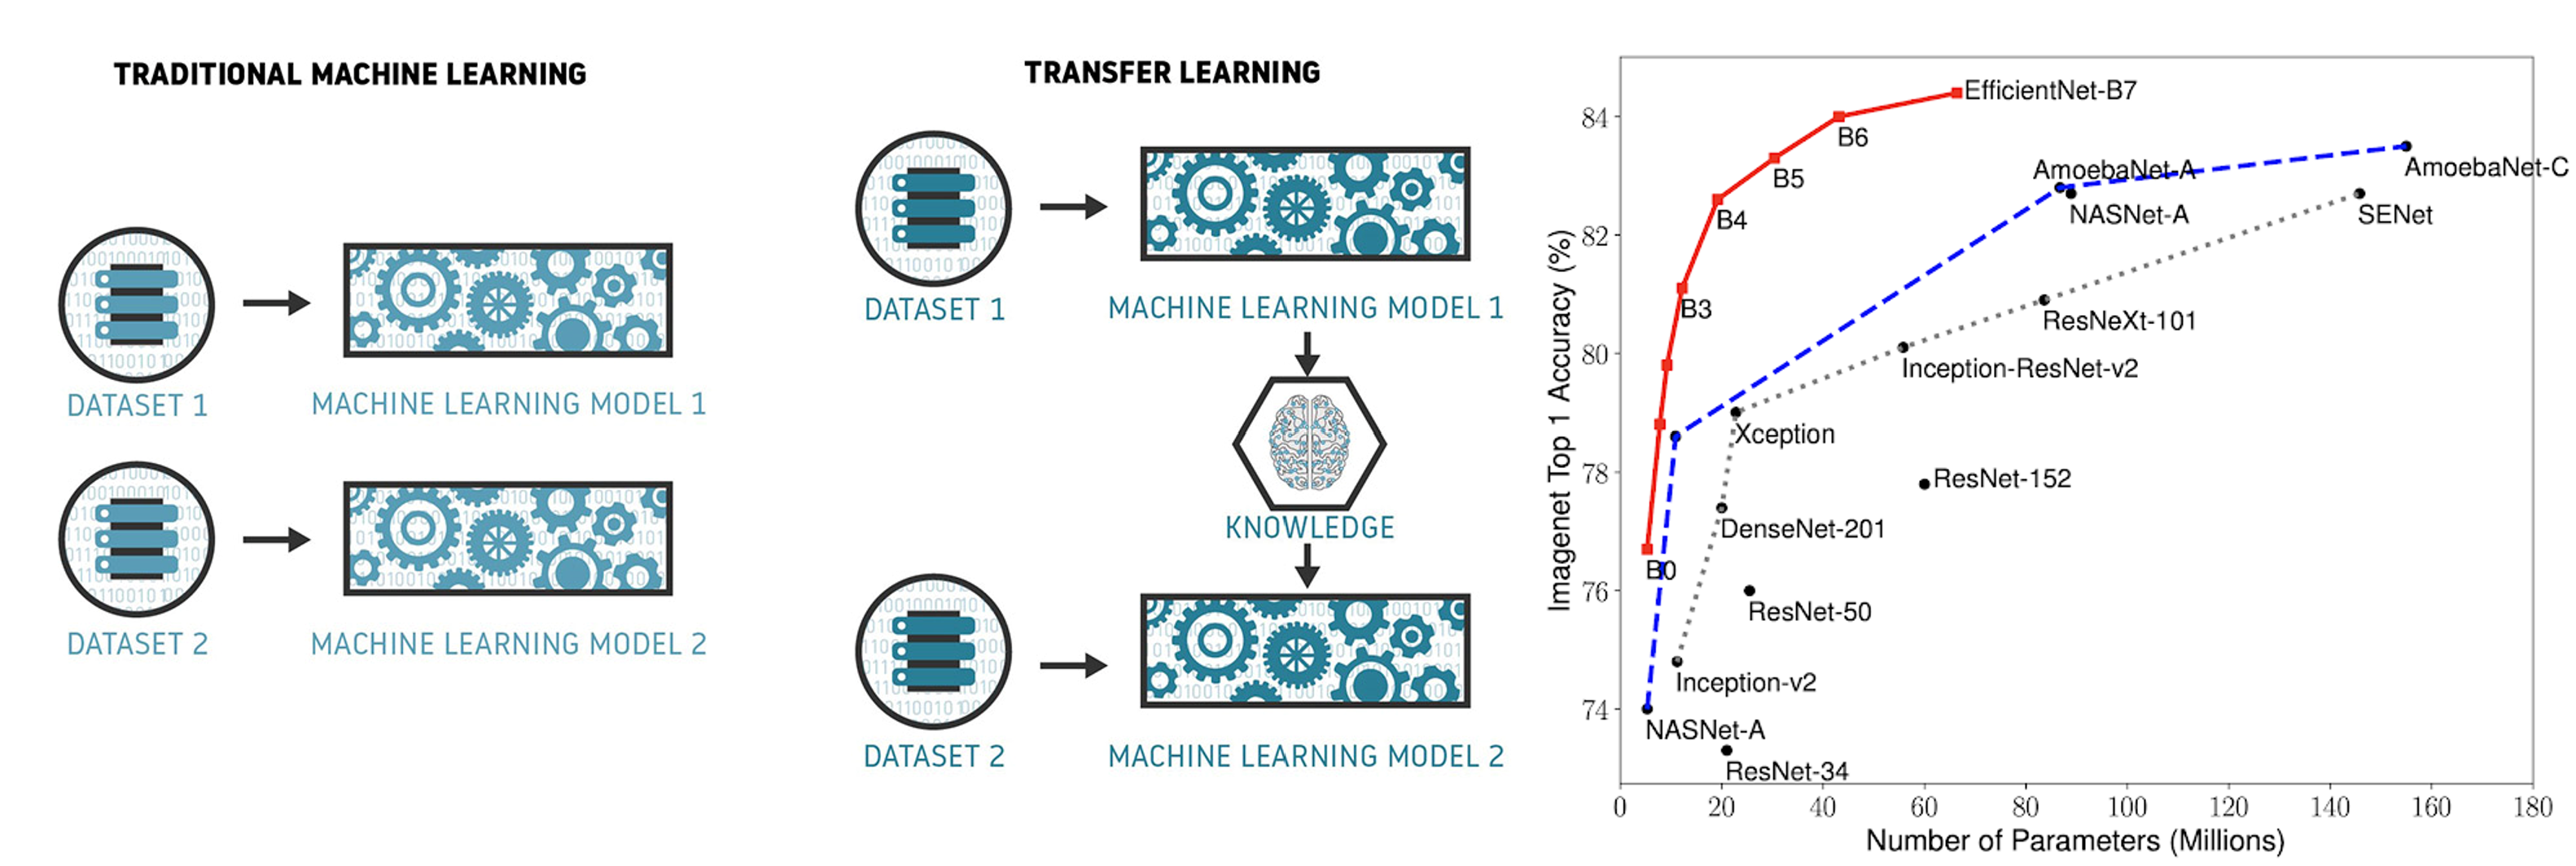

Here are some key points to know about transfer learning:

- Transfer learning involves using pre-trained models as a starting point for new machine learning tasks.

- The pre-trained models are typically trained on large and diverse datasets, such as ImageNet, and have learned useful features that can be applied to new tasks.

- Instead of training a new model from scratch for a specific task, transfer learning allows us to use the pre-trained model as a starting point and then fine-tune it on a smaller dataset that is specific to the new task.

- Fine-tuning involves updating the parameters of the pre-trained model using the new dataset, while keeping the learned features intact.

- Transfer learning can help improve the performance of a model on a new task, especially when the new dataset is small or when there is limited computing resources.

- Transfer learning is widely used in computer vision and natural language processing tasks, such as image classification, object detection, and language translation.

- Some popular pre-trained models that are commonly used for transfer learning include VGG, ResNet, and BERT.

# Dataset Loading tf_flowers

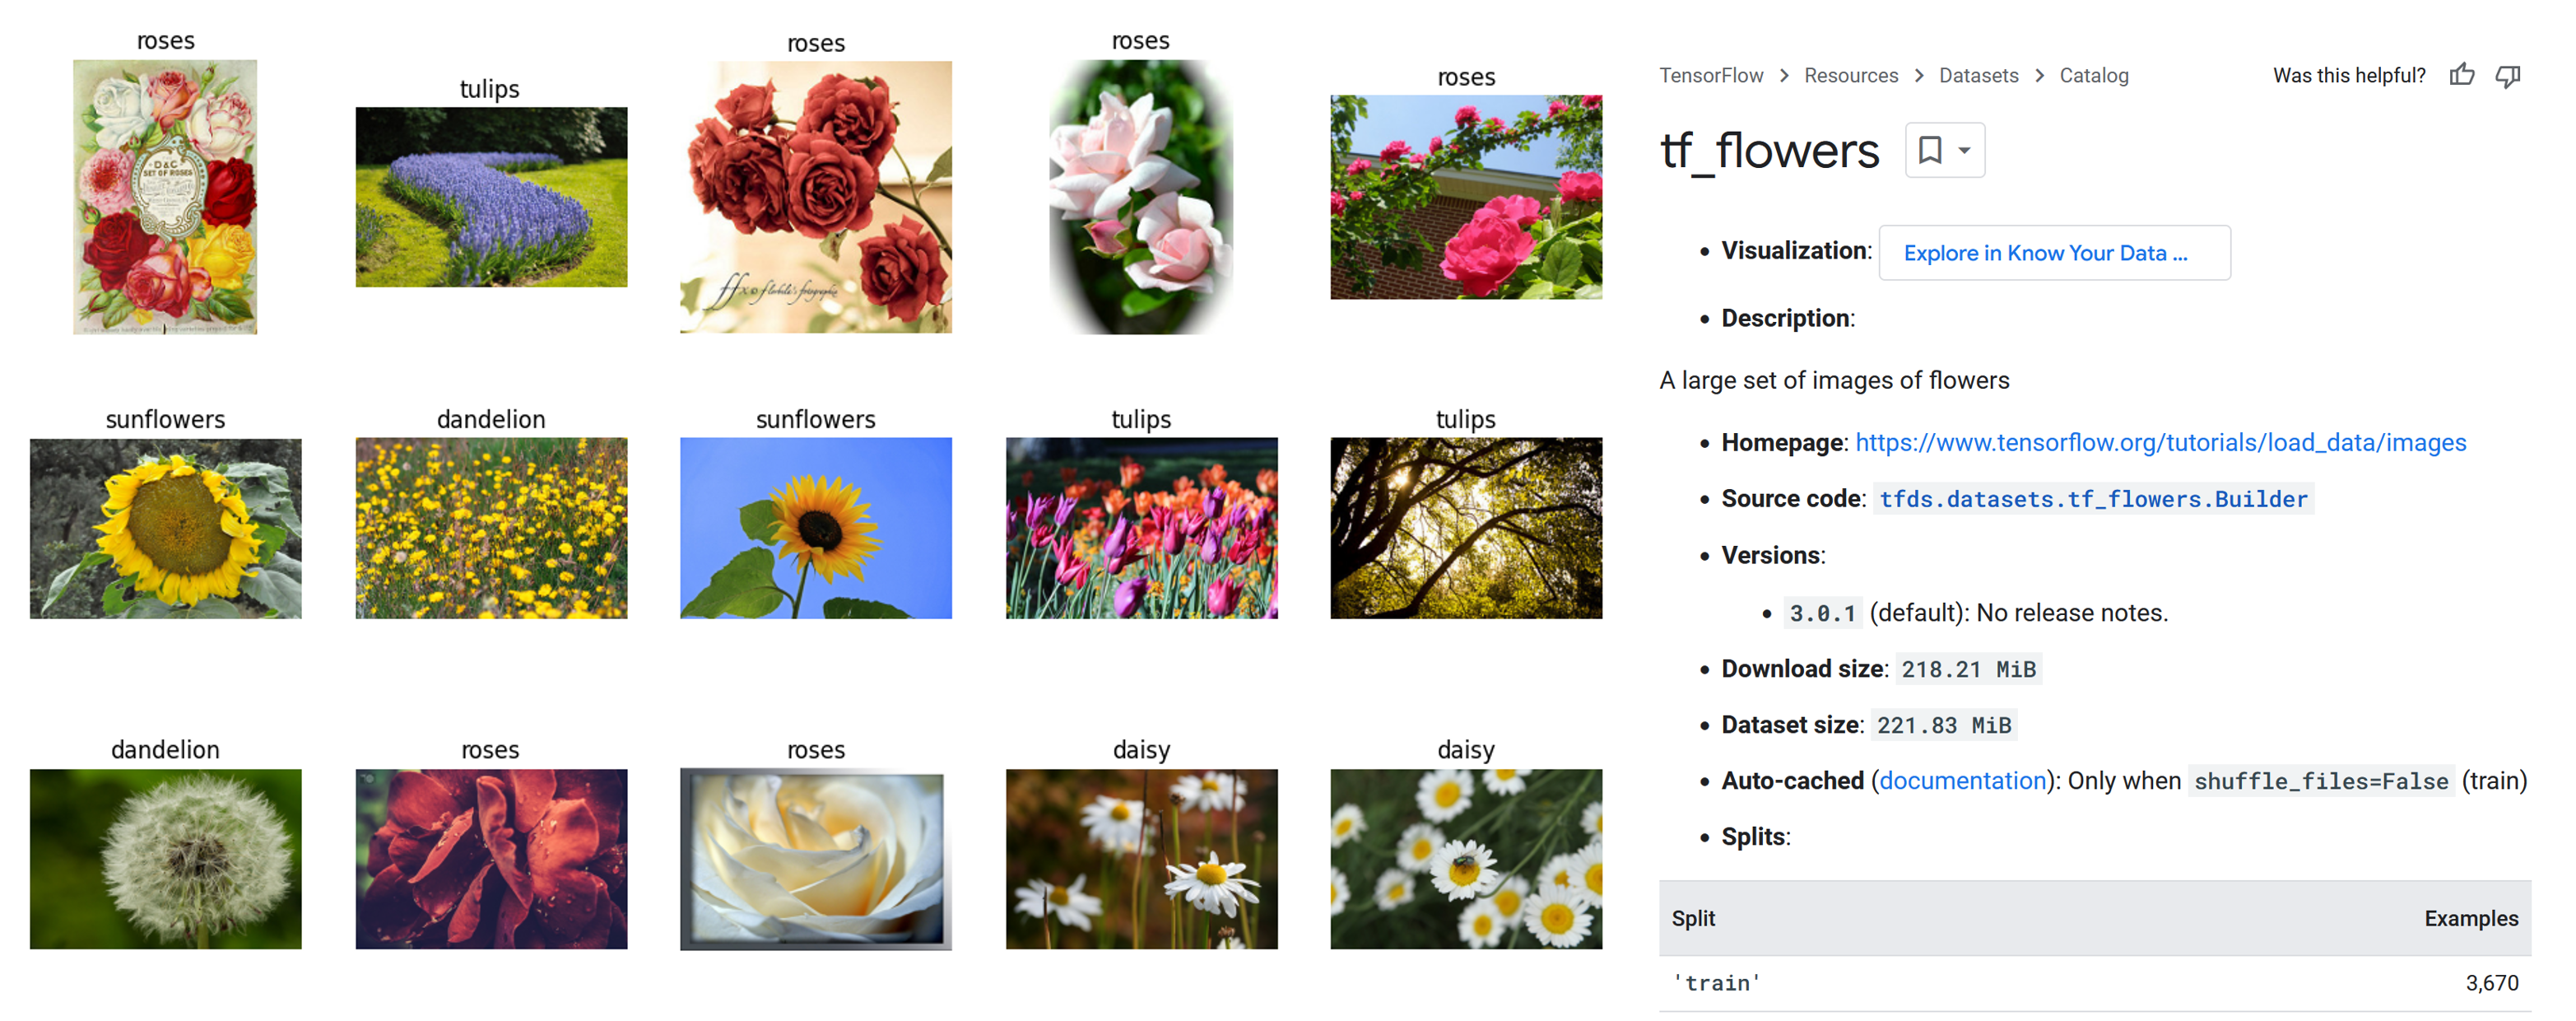

In [1]:
import tensorflow as tf
import tensorflow_datasets as tfds
import os

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import torch

ModuleNotFoundError: No module named 'tensorflow_datasets'

In [ ]:
dataset, info = tfds.load('tf_flowers', with_info=True, as_supervised=True)

In [ ]:
# supervised_keys=('image', 'label')
class_names = info.features['label'].names
class_names

['dandelion', 'daisy', 'tulips', 'sunflowers', 'roses']

In [ ]:
for i, example in enumerate(dataset['train']):
  image,label = example
  save_dir = 'tf_flowers/train/{}'.format(class_names[label])
  os.makedirs(save_dir, exist_ok=True)

  filepath = save_dir + "/" + "{}_{}.jpg".format(class_names[label], i)
  tf.keras.preprocessing.image.save_img(filepath, image.numpy())
  # print(filepath)
  # break

# Transfer Learning

## Model Improvements with augmentation and VGG16 blocks

## Building Baseline CNN Model

A baseline model will establish a minimum model performance to which all of our other models can be compared, as well as a model architecture that we can use as the basis of study and improvement.

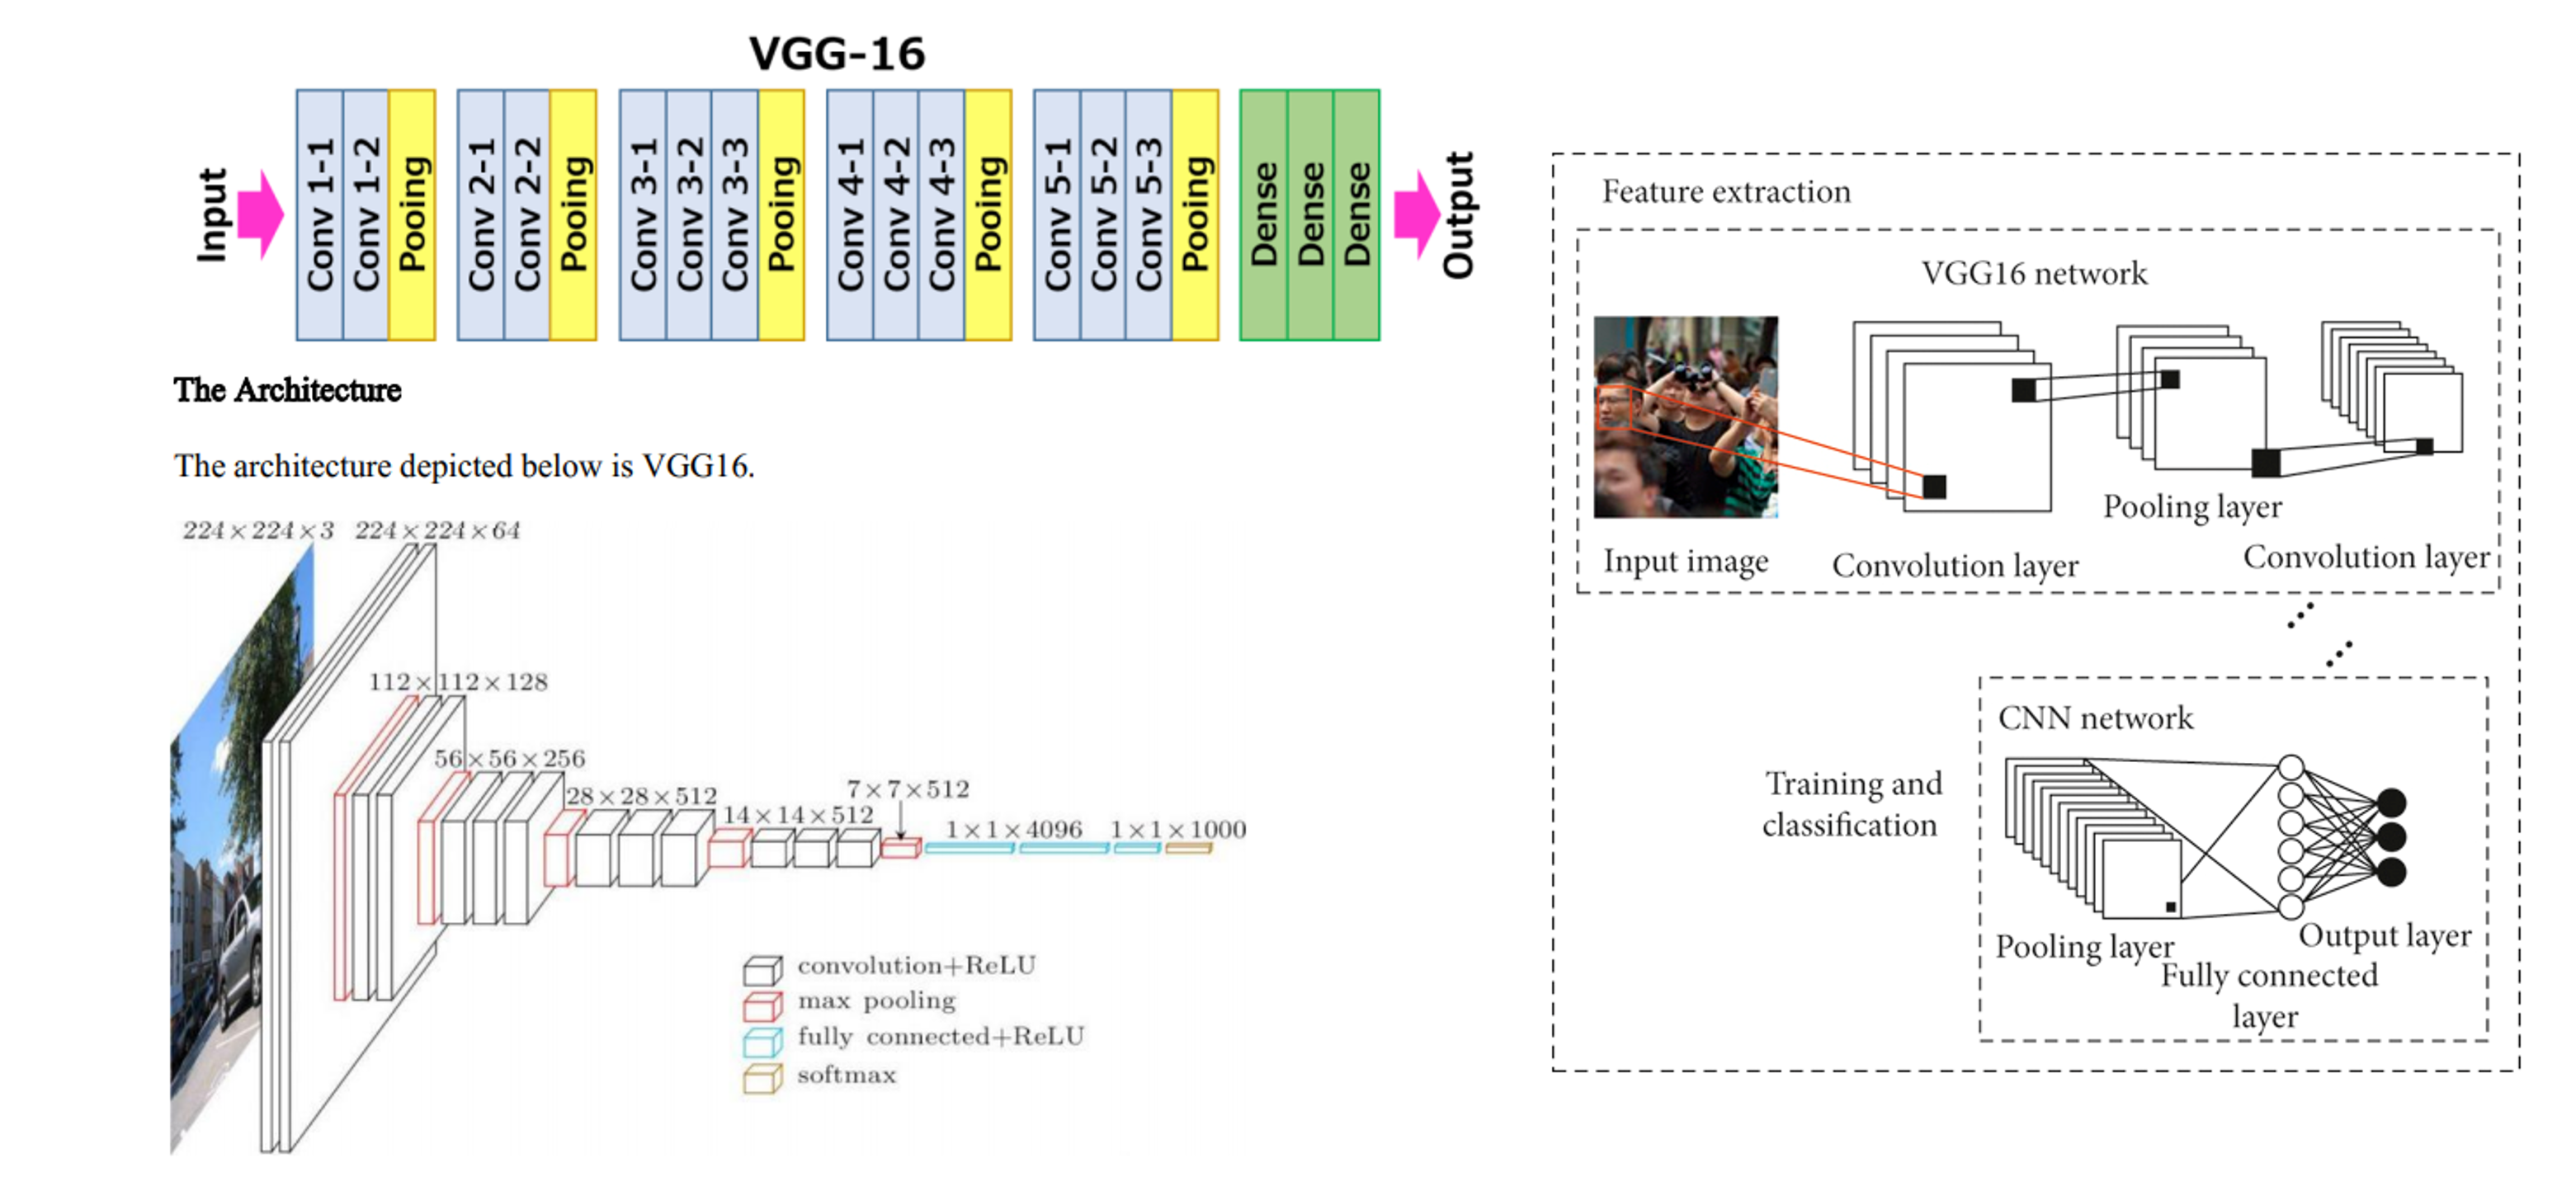

In [ ]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from tensorflow.keras.models import Sequential

In [ ]:
datagen = ImageDataGenerator(rescale=1/255, validation_split=0.2,
                             rotation_range=10, width_shift_range = 0.1, height_shift_range=0.1,
                             shear_range=0.1, zoom_range=0.1, horizontal_flip=True)

train_generator = datagen.flow_from_directory('tf_flowers/train', target_size=(224,224), batch_size=4, 
                                              class_mode="categorical", subset='training')

validation_generator = datagen.flow_from_directory('tf_flowers/train', target_size=(224,224), batch_size=4, 
                                              class_mode="categorical", subset='validation')


Found 2939 images belonging to 5 classes.
Found 731 images belonging to 5 classes.


In [ ]:
# create base model
model = Sequential()
model.add(Conv2D(64, (3, 3), activation='relu', input_shape=(224, 224, 3)))
model.add(Conv2D(64, (3, 3), activation='relu'))
model.add(MaxPooling2D((2, 2)))
model.add(Dropout(0.2))

model.add(Conv2D(128, (3, 3), activation='relu'))
model.add(Conv2D(128, (3, 3), activation='relu'))
model.add(MaxPooling2D((2, 2)))
model.add(Dropout(0.2))

model.add(Flatten())
model.add(Dense(512, activation='relu'))
model.add(Dropout(0.5))

model.add(Dense(5, activation='softmax'))

opt = tf.keras.optimizers.Adam(learning_rate=0.0001)
model.compile(loss='categorical_crossentropy', optimizer=opt, metrics=['accuracy'])


In [ ]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 222, 222, 64)      1792      
                                                                 
 conv2d_1 (Conv2D)           (None, 220, 220, 64)      36928     
                                                                 
 max_pooling2d (MaxPooling2D  (None, 110, 110, 64)     0         
 )                                                               
                                                                 
 dropout (Dropout)           (None, 110, 110, 64)      0         
                                                                 
 conv2d_2 (Conv2D)           (None, 108, 108, 128)     73856     
                                                                 
 conv2d_3 (Conv2D)           (None, 106, 106, 128)     147584    
                                                        

In [ ]:
history=model.fit(train_generator, epochs=5, validation_data=validation_generator)

Epoch 1/5
735/735 [==============================] - 79s 103ms/step - loss: 1.2979 - accuracy: 0.4481 - val_loss: 1.1491 - val_accuracy: 0.4843
Epoch 2/5
735/735 [==============================] - 82s 112ms/step - loss: 1.1031 - accuracy: 0.5522 - val_loss: 1.0062 - val_accuracy: 0.6115
Epoch 3/5
735/735 [==============================] - 75s 102ms/step - loss: 0.9854 - accuracy: 0.6148 - val_loss: 1.0257 - val_accuracy: 0.5814
Epoch 4/5
735/735 [==============================] - 75s 101ms/step - loss: 0.9059 - accuracy: 0.6536 - val_loss: 0.8866 - val_accuracy: 0.6717
Epoch 5/5
735/735 [==============================] - 74s 101ms/step - loss: 0.8527 - accuracy: 0.6666 - val_loss: 0.8196 - val_accuracy: 0.6895


In [ ]:
# VGG 16 Model
from tensorflow.keras.applications import VGG16
model_vgg16 = VGG16(input_shape=(224,224,3), include_top=False, weights='imagenet')

58889256/58889256 [==============================] - 2s 0us/step


In [ ]:
for layer in model_vgg16.layers:
  layer.trainable=False

model_vgg16.summary()


Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 56, 56, 128)       0     

In [ ]:
model = Sequential()
model.add(model_vgg16)
model.add(Flatten())
model.add(Dense(512, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(5, activation='softmax'))

model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vgg16 (Functional)          (None, 7, 7, 512)         14714688  
                                                                 
 flatten_2 (Flatten)         (None, 25088)             0         
                                                                 
 dense_4 (Dense)             (None, 512)               12845568  
                                                                 
 dropout_6 (Dropout)         (None, 512)               0         
                                                                 
 dense_5 (Dense)             (None, 5)                 2565      
                                                                 
Total params: 27,562,821
Trainable params: 12,848,133
Non-trainable params: 14,714,688
_________________________________________________________________


In [ ]:
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
history=model.fit(train_generator, epochs=5, validation_data=validation_generator)

Epoch 1/5
735/735 [==============================] - 65s 85ms/step - loss: 1.6341 - accuracy: 0.5441 - val_loss: 0.8056 - val_accuracy: 0.7059
Epoch 2/5
735/735 [==============================] - 60s 82ms/step - loss: 0.9377 - accuracy: 0.6349 - val_loss: 0.6417 - val_accuracy: 0.7538
Epoch 3/5
735/735 [==============================] - 60s 81ms/step - loss: 0.8579 - accuracy: 0.6696 - val_loss: 0.6098 - val_accuracy: 0.7633
Epoch 4/5
735/735 [==============================] - 59s 80ms/step - loss: 0.7856 - accuracy: 0.6955 - val_loss: 0.6307 - val_accuracy: 0.7729
Epoch 5/5
735/735 [==============================] - 60s 82ms/step - loss: 0.7808 - accuracy: 0.6938 - val_loss: 0.6146 - val_accuracy: 0.7674


In [ ]:
model.save('flowers_classifier.h5')

In [ ]:
flowers = tf.keras.models.load_model('flowers_classifier.h5')

In [ ]:
flowers.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vgg16 (Functional)          (None, 7, 7, 512)         14714688  
                                                                 
 flatten_2 (Flatten)         (None, 25088)             0         
                                                                 
 dense_4 (Dense)             (None, 512)               12845568  
                                                                 
 dropout_6 (Dropout)         (None, 512)               0         
                                                                 
 dense_5 (Dense)             (None, 5)                 2565      
                                                                 
Total params: 27,562,821
Trainable params: 12,848,133
Non-trainable params: 14,714,688
_________________________________________________________________


In [ ]:
import cv2

img = cv2.imread('/content/tf_flowers/train/roses/roses_1054.jpg')
img = cv2.resize(img, (224,224))
img = np.reshape(img, [1,224,224,3])
img = img/255

preds = flowers.predict(img)

max_idx = np.argmax(preds)
class_indices = {v:k for k,v in train_generator.class_indices.items()}
class_indices[max_idx]


1/1 [==============================] - 0s 29ms/step


'roses'

3

'sunflowers'